# Visualize the Test Image and its k-NN

Here we illustrates the test image and its nearest neighbors from our augmented dataset. By precomputing adversarial examples, its k-NN have diverse label, which is critical for cleansing the model and unlearn non-robust patterns.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
BASE_DIR = ''
# Original training dataset
TRAIN_DATA_DIR = ''
TRAIN_LABEL_DIR = ''
# Augmented dataset
AUG_DATA_DIR_1 = ''
AUG_DATA_DIR_2 = ''
AUG_DATA_DIR_3 = ''
AUG_FEATURES = ''

# Clean evaluation dataset
EVAL_DATA_DIR = ''
EVAL_LABEL_DIR = ''
EVAL_FEATURES = ''

# Adversarial perturbed evaluation dataset
ATTACK_DATA_DIR = ')'
# Target attack label(used to calculate attack success rate)
ATTACK_LABEL_DIR = ''
# Features(hidden representations)
ATTACK_FEATURES = ''

BUFFER_SIZE = 10000
IMG_SIZE = 224
RESIZE_SIZE = 256
BATCH_SIZE = 128
K = 2048
EPOCHS = 100
EARLY_STOP = 5
LEARNING_RATE = 1e-5

In [4]:
# Prepare dataset
# Training data
train_path = np.load(BASE_DIR + TRAIN_DATA_DIR)
train_label = np.load(BASE_DIR + TRAIN_LABEL_DIR)
assert len(train_path) == len(train_label)

# Evaluation data
eval_path = np.load(BASE_DIR + EVAL_DATA_DIR)
eval_label = np.load(BASE_DIR + EVAL_LABEL_DIR)
assert len(eval_path) == len(eval_label)

# Targeted class used in targeted-attack
target_label = np.load(BASE_DIR + ATTACK_LABEL_DIR)

# Map prediction to corresponding class name
pkl_file = open(BASE_DIR + '/data/imagenet_label.pkl', 'rb')
label_dict = pickle.load(pkl_file)
pkl_file.close()

In [5]:
def feature_dataset_generator(feature, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(feature)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def resize_image(image, shape=(224,224)):
    target_width = shape[0]
    target_height = shape[1]
    initial_width = tf.shape(image)[0]
    initial_height = tf.shape(image)[1]
    im = image
    ratio = 0
    if(initial_width < initial_height):
        ratio = tf.cast(256 / initial_width, tf.float32)
        h = tf.cast(initial_height, tf.float32) * ratio
        im = tf.image.resize(im, (256, h), method="bicubic")
    else:
        ratio = tf.cast(256 / initial_height, tf.float32)
        w = tf.cast(initial_width, tf.float32) * ratio
        im = tf.image.resize(im, (w, 256), method="bicubic")
    width = tf.shape(im)[0]
    height = tf.shape(im)[1]
    startx = width//2 - (target_width//2)
    starty = height//2 - (target_height//2)
    im = tf.image.crop_to_bounding_box(im, startx, starty, target_width, target_height)
    return im

def scale19(image):
    i = resize_image(image, (224,224))
    return (i)

In [6]:
# Load precomputed features(hidden representation)to accelerate searching k-NN
# See more details in "/prepare/extract_feature.py"
feature_list = np.load(AUG_FEATURES)
feature_ds = feature_dataset_generator(feature_list, 2048)

In [7]:
pgd_path_10 = []
pgd_path_30 = []
pgd_path_100 = []

for path in train_path:
    pgd_path_10.append(path.replace('train_set', AUG_DATA_DIR_1).replace('JPEG', 'png'))
    pgd_path_30.append(path.replace('train_set', AUG_DATA_DIR_2).replace('JPEG', 'png'))
    pgd_path_100.append(path.replace('train_set', AUG_DATA_DIR_3).replace('JPEG', 'png'))

pgd_path_10 = np.asarray(pgd_path_10)
pgd_path_30 = np.asarray(pgd_path_30)
pgd_path_100 = np.asarray(pgd_path_100)

adapt_path = np.concatenate([pgd_path_10, pgd_path_30], axis=0)
adapt_path = np.concatenate([adapt_path, pgd_path_100], axis=0)
adapt_path = np.concatenate([adapt_path, train_path], axis=0)

adapt_label = np.concatenate([train_label, train_label], axis=0)
adapt_label = np.concatenate([adapt_label, train_label], axis=0)
adapt_label = np.concatenate([adapt_label, train_label], axis=0)

assert len(adapt_path) == len(adapt_label)

In [8]:
def ResNet152V2():
    IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
    resnet152v2 = tf.keras.applications.ResNet152V2(include_top=True,
                                                    weights='imagenet',
                                                    input_shape=IMG_SHAPE, 
                                                    classes=1000)
    return resnet152v2

In [9]:
resnet152v2 = ResNet152V2()

In [10]:
# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return tf.keras.applications.resnet_v2.decode_predictions(probs.numpy(), top=1)[0][0]

def display_images(image, description):
    new_image = np.clip(image, 0, 1)
    image = image[tf.newaxis, :]
    image = tf.keras.applications.resnet_v2.preprocess_input(image*255)
    prediction_probabilities = resnet152v2(image)
    _, label, confidence = get_imagenet_label(prediction_probabilities)
#     print('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
    
    plt.figure()
    plt.axis('off')
    plt.imshow(new_image)
    plt.title('{} \n {} : {:.2f}% confidence'.format(description, label, confidence*100))
    plt.show()

## Clean Image

Query Image


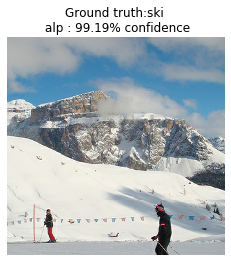

k-Nearest Neighbors


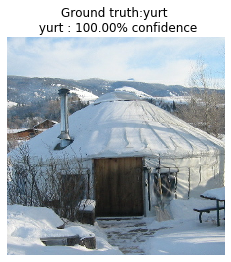

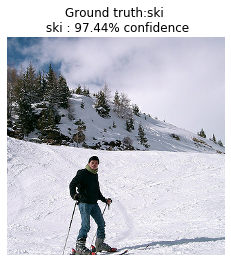

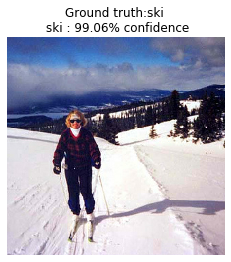

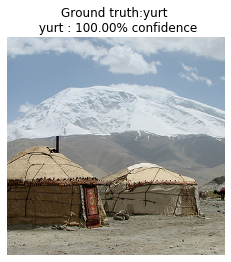

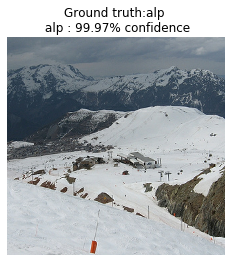

In [11]:
# Visualize selected evaluation data and its nearest neighbors
idx = 10000

# Load test data
img = tf.io.read_file(eval_path[idx])
img = tf.image.decode_image(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = scale19(img)

# Extract feature
adv_repre = np.load(eval_path[idx].replace('val_set', 'repre_resnet152_conv5_1_eval_clean').replace('JPEG', 'npy'))
adv_repre = tf.convert_to_tensor(adv_repre)

# Find KNN based on Euclidean distance
l2_norm_list = []
for feature in feature_ds:
    l2_norm = tf.norm(adv_repre - feature, ord='euclidean', axis=1)
    l2_norm_list.append(l2_norm.numpy())

l2_norm = np.hstack(l2_norm_list)
knn_idx = l2_norm.argsort()[:10]

# Visualize test data
print("Query Image")
display_images(img, "Ground truth:{:s}".format(label_dict[eval_label[idx]]))

# Visualize k-NN
print("k-Nearest Neighbors")
for i in range(0, 5):
    img = tf.io.read_file(adapt_path[knn_idx[i]])
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = scale19(img)
    display_images(img, "Ground truth:{:s}".format(label_dict[adapt_label[knn_idx[i]]]))

## PGD(8/255)

Query Image


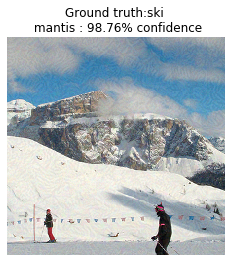

k-Nearest Neighbors


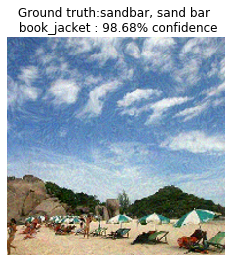

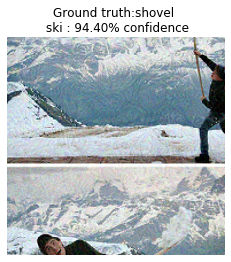

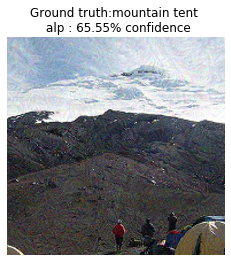

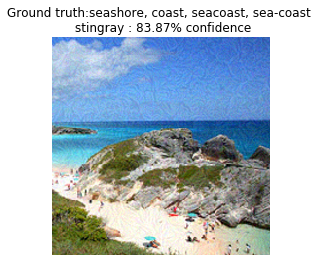

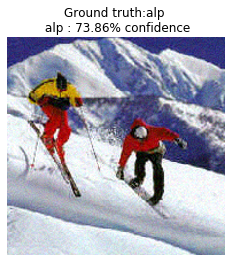

In [12]:
# Load test data
adv_img = np.load(eval_path[idx].replace('val_set', 'val_set_pgd_8_10_0.01_target(resnet152)').replace('JPEG', 'npy'))
adv_img = tf.convert_to_tensor(adv_img)

# Extract feature
adv_repre = np.load(eval_path[idx].replace('val_set', 'repre_resnet152_conv5_1_eval_8_target').replace('JPEG', 'npy'))
adv_repre = tf.convert_to_tensor(adv_repre)

# Find KNN based on Euclidean distance
l2_norm_list = []
for feature in feature_ds:
    l2_norm = tf.norm(adv_repre - feature, ord='euclidean', axis=1)
    l2_norm_list.append(l2_norm.numpy())

l2_norm = np.hstack(l2_norm_list)
knn_idx = l2_norm.argsort()[:10]

# Visualize test data
print("Query Image")
display_images(adv_img, "Ground truth:{:s}".format(label_dict[eval_label[idx]]))

# Visualize k-NN
print("k-Nearest Neighbors")
for i in range(0, 5):
    img = tf.io.read_file(adapt_path[knn_idx[i]])
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = scale19(img)
    display_images(img, "Ground truth:{:s}".format(label_dict[adapt_label[knn_idx[i]]]))

## PGD(16/255)

Query Image


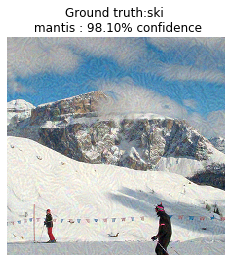

k-Nearest Neighbors


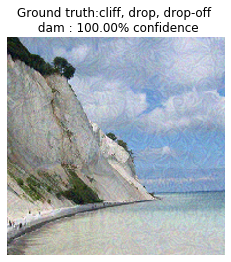

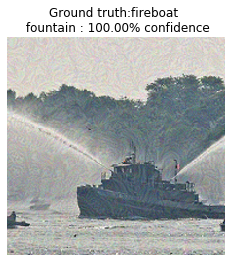

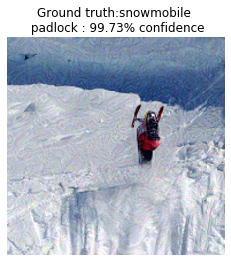

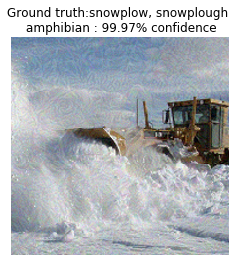

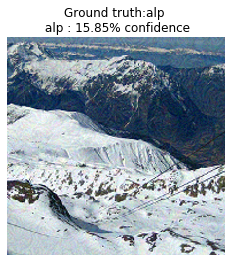

In [13]:
# Load test data
adv_img = np.load(eval_path[idx].replace('val_set', 'val_set_pgd_16_10_0.01_target(resnet152)').replace('JPEG', 'npy'))
adv_img = tf.convert_to_tensor(adv_img)

# Extract feature
adv_repre = np.load(eval_path[idx].replace('val_set', 'repre_resnet152_conv5_1_eval_16_target').replace('JPEG', 'npy'))
adv_repre = tf.convert_to_tensor(adv_repre)

# Find KNN based on Euclidean distance
l2_norm_list = []
for feature in feature_ds:
    l2_norm = tf.norm(adv_repre - feature, ord='euclidean', axis=1)
    l2_norm_list.append(l2_norm.numpy())

l2_norm = np.hstack(l2_norm_list)
knn_idx = l2_norm.argsort()[:10]

# Visualize test data
print("Query Image")
display_images(adv_img, "Ground truth:{:s}".format(label_dict[eval_label[idx]]))

# Visualize k-NN
print("k-Nearest Neighbors")
for i in range(0, 5):
    img = tf.io.read_file(adapt_path[knn_idx[i]])
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = scale19(img)
    display_images(img, "Ground truth:{:s}".format(label_dict[adapt_label[knn_idx[i]]]))